In [1]:
%load_ext autoreload
%autoreload 3
%matplotlib inline

In [2]:
import logging
import pandas as pd
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt

from cnaster.config import JSONConfig
from cnaster.io import get_spots, get_meta, get_umis
from cnaster.sim.io import get_truth
from cnaster.sim.clone import (
    construct_frac_cnas,
    get_cnas,
)

In [3]:
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(name)s - %(levelname)s - %(filename)s:%(lineno)d - %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
)

logger = logging.getLogger(__name__)

# NOTES
- current sim. configuration assumes tumor purity of unity

In [4]:
run_id = 0
cpath = "/Users/mw9568/repos/cnaster/sim_config.json"
sample_name = "cnaster_002"

config = JSONConfig.from_file(cpath)

In [5]:
spots = get_spots(config, run_id, sample_name)
meta = get_meta(config, run_id, sample_name)
truth = get_truth(config, run_id, sample_name)

df = pd.merge(spots, meta, on="barcode")
df = pd.merge(df, truth, on="barcode")
df

2025-06-17 11:04:34 - cnaster.io - INFO - io.py:13 - Reading spots from /Users/mw9568/scratch/cnaster/run0/cnaster_002/cnaster_002_visium.tsv.gz


,barcode,x,y,z,umis,snp_umis,clone,tumor_purity
0,VIS00000,-15.0,0.000000,2.5,3806,464,-1,0.0
1,VIS00001,-14.0,0.000000,2.5,2679,485,-1,0.0
2,VIS00002,-13.0,0.000000,2.5,1509,660,-1,0.0
3,VIS00003,-12.0,0.000000,2.5,4619,347,-1,0.0
4,VIS00004,-11.0,0.000000,2.5,3190,568,-1,0.0
...,...,...,...,...,...,...,...,...
4895,VIS04895,84.5,59.755753,2.5,2263,301,-1,0.0
4896,VIS04896,85.5,59.755753,2.5,3004,439,-1,0.0
4897,VIS04897,86.5,59.755753,2.5,4192,353,-1,0.0
4898,VIS04898,87.5,59.755753,2.5,3642,493,-1,0.0


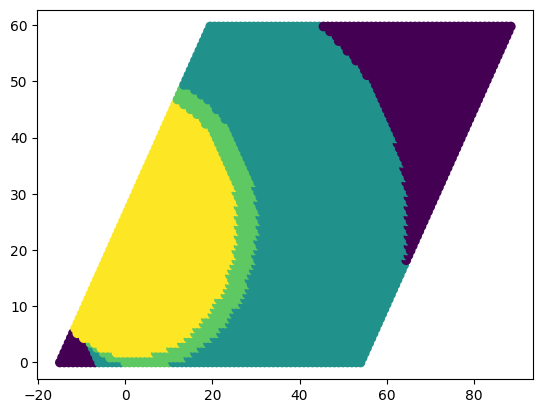

In [6]:
pl.scatter(df["x"], df["y"], c=df["clone"])

In [7]:
clone_ids = np.unique(df["clone"])
clone_ids

array([-1,  1,  2,  3])

In [8]:
cnas_per_clone = get_cnas(config, clone_ids)

Text(0, 0.5, 'BAF')

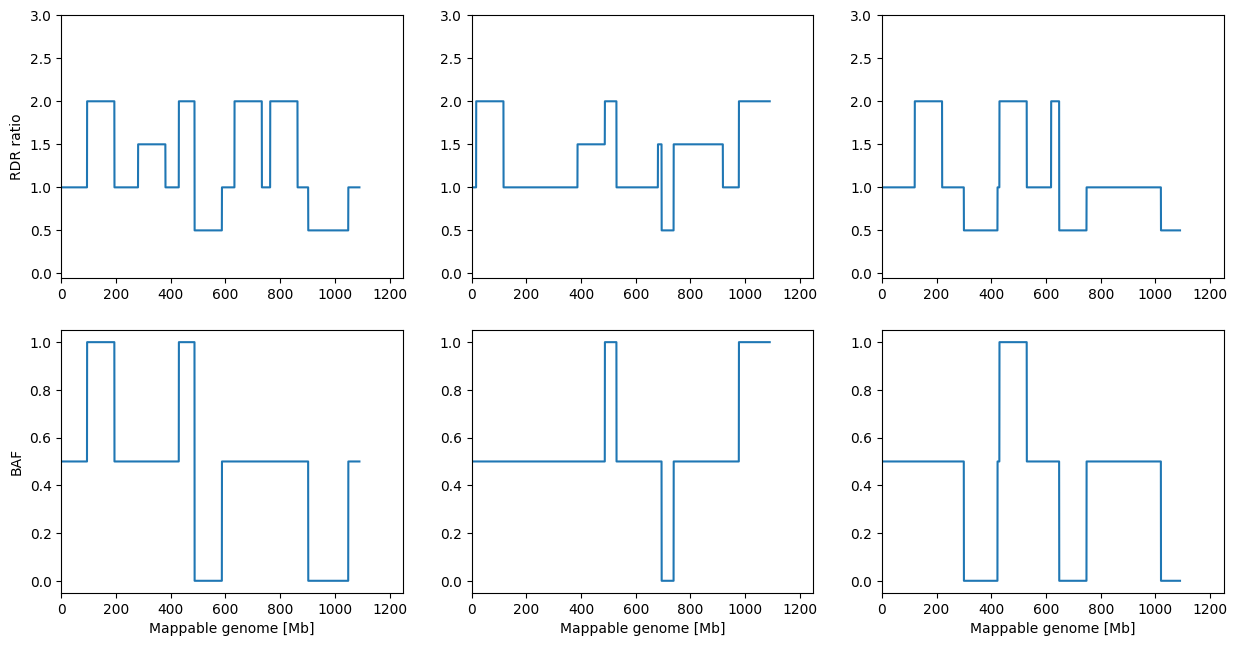

In [11]:
num_segments = config.mappable_genome_kbp // config.segment_size_kbp
segments_mb = (config.segment_size_kbp / 1.0e3) * np.arange(num_segments)

fig, axes = plt.subplots(2, len(cnas_per_clone), figsize=(15, 7.5))

for ii, cnas in enumerate(cnas_per_clone):
    rdrs, bafs = construct_frac_cnas(num_segments, config.segment_size_kbp, 1.0, cnas)

    # NB plot RDRs
    axes[0, ii].plot(segments_mb, rdrs)
    axes[1, ii].set_xlabel("Mappable genome [Mb]")

    axes[0, ii].set_xlim(0.0, 1.25e3)
    axes[0, ii].set_ylim(-0.05, 3.0)

    # NB plot BAFs
    axes[1, ii].plot(segments_mb, bafs)

    axes[1, ii].set_xlim(0.0, 1.25e3)
    axes[1, ii].set_ylim(-0.05, 1.05)

axes[0, 0].set_ylabel("RDR ratio")
axes[1, 0].set_ylabel("BAF")

In [10]:
umis = get_umis(config, run_id, sample_name)
umis

array([[[4., 0., 2., ..., 1., 0., 0.],
        [2., 0., 0., ..., 5., 1., 0.],
        [1., 0., 0., ..., 1., 0., 0.],
        ...,
        [2., 0., 2., ..., 0., 2., 0.],
        [4., 9., 2., ..., 0., 0., 0.],
        [4., 3., 0., ..., 1., 0., 0.]],

       [[1., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        ...,
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

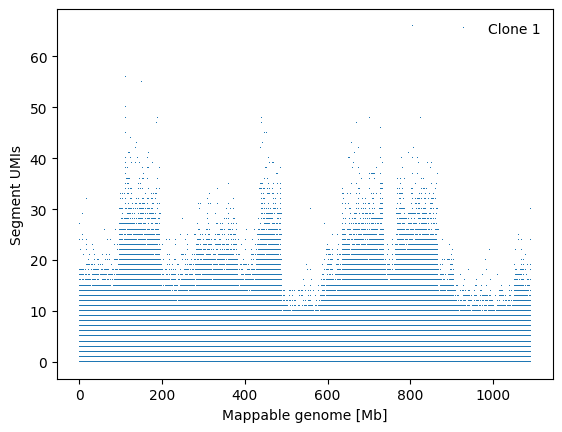

In [18]:
isin = df["clone"] == 1

tiled_segments = np.tile(segments_mb, np.count_nonzero(isin))
tiled_umis = umis[0, isin, :].flatten()

pl.plot(tiled_segments, tiled_umis, marker=",", lw=0.0, label="Clone 1")

pl.xlabel("Mappable genome [Mb]")
pl.ylabel("Segment UMIs")

pl.legend(frameon=False)

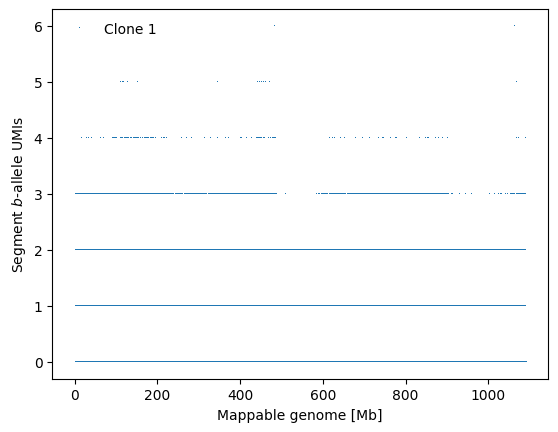

In [20]:
isin = df["clone"] == 1

tiled_segments = np.tile(segments_mb, np.count_nonzero(isin))
tiled_snp_umis = umis[1, isin, :].flatten()

pl.plot(tiled_segments, tiled_snp_umis, marker=",", lw=0.0, label="Clone 1")

pl.xlabel("Mappable genome [Mb]")
pl.ylabel("Segment $b$-allele UMIs")

pl.legend(frameon=False)

# Done.